In [ ]:
pip install seaborn

import mlflow
import mlflow.sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import pandas as pd

def entrenar_modelo_iris():
    # Configurar MLflow
    mlflow.set_experiment("clasificacion_iris_detallada_2")
    
    # Cargar datos
    iris = load_iris()
    X, y = iris.data, iris.target
    
    # Dividir datos
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Escalar características
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Crear signature del modelo
    input_example = X_test_scaled[:5]  # Using first 5 samples from test set
    # Iniciar run de MLflow
    with mlflow.start_run():
        # Crear modelo de Regresión Logística
        modelo = LogisticRegression(max_iter=200, multi_class='ovr')
        modelo.fit(X_train_scaled, y_train)
        
        # Predecir
        predicciones = modelo.predict(X_test_scaled)
        
        # Calcular métricas
        accuracy = accuracy_score(y_test, predicciones)
        
        # Matriz de Confusión
        cm = confusion_matrix(y_test, predicciones)
        
        # Visualizar Matriz de Confusión
        plt.figure(figsize=(8,6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=iris.target_names, 
                    yticklabels=iris.target_names)
        plt.title('Matriz de Confusión - Clasificación Iris')
        plt.xlabel('Predicción')
        plt.ylabel('Valor Real')
        plt.tight_layout()
        
        # Guardar figura
        plt.savefig('confusion_matrix.png')
        
        # Registrar métricas y parámetros en MLflow
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_param("modelo", "Regresión Logística")
        mlflow.log_param("max_iter", 200)
        
        # Registrar la imagen de la matriz de confusión
        mlflow.log_artifact('confusion_matrix.png')
        
        # Guardar modelo
        mlflow.sklearn.log_model(modelo, "modelo_iris",  input_example=input_example)
        
        # Imprimir resultados
        print("Accuracy:", accuracy)
        print("\nReporte de Clasificación:")
        print(classification_report(y_test, predicciones, target_names=iris.target_names))

        # Predicciones y probabilidades
        predicciones = modelo.predict(X_test_scaled)
        probas = modelo.predict_proba(X_test_scaled)

        # Construir DataFrame de evaluación
        df_eval = pd.DataFrame(X_test, columns=iris.feature_names)
        df_eval['true_label'] = [iris.target_names[i] for i in y_test]
        df_eval['predicted_label'] = [iris.target_names[i] for i in predicciones]

        for i, name in enumerate(iris.target_names):
            df_eval[f'prob_{name}'] = probas[:, i]
        print(df_eval.head())
        # Loguear la tabla como artifact en MLflow.
        # Intentamos usar mlflow.log_table (si está disponible); si no, guardamos CSV y usamos mlflow.log_artifact.
        import tempfile
        import os

        # Crear archivo temporal
        with tempfile.TemporaryDirectory() as tmpdir:
            path_csv = os.path.join(tmpdir, "evaluation_table.csv")
            df_eval.to_csv(path_csv, index=False)
            mlflow.log_artifact(path_csv, artifact_path="evaluation")

        # Crear carpeta temporal y guardar el DataFrame como JSON
        with tempfile.TemporaryDirectory() as tmpdir:
            path_json = os.path.join(tmpdir, "evaluation_table.json")
        
            # Guardar en formato JSON (una línea por registro)
            df_eval.to_json(path_json, orient="records", lines=True)
        
            # Loguear como artifact en MLflow
            mlflow.log_table(df_eval, artifact_file="evaluation_table.json")


ModuleNotFoundError: No module named 'seaborn'

In [4]:
from sklearn.ensemble import RandomForestClassifier

def entrenar_modelo_iris_rf():
    
    mlflow.set_experiment("clasificacion_iris_detallada_2")
    
    # Cargar datos
    iris = load_iris()
    X, y = iris.data, iris.target
    
    # Dividir datos
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Escalar características
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    input_example = X_test_scaled[:5]
    
    with mlflow.start_run():
        # Crear modelo Random Forest
        modelo = RandomForestClassifier(n_estimators=100, random_state=42)
        modelo.fit(X_train_scaled, y_train)
        
        predicciones = modelo.predict(X_test_scaled)
        accuracy = accuracy_score(y_test, predicciones)
        
        # Matriz de Confusión
        cm = confusion_matrix(y_test, predicciones)
        plt.figure(figsize=(8,6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=iris.target_names, 
                    yticklabels=iris.target_names)
        plt.title('Matriz de Confusión - Random Forest')
        plt.xlabel('Predicción')
        plt.ylabel('Valor Real')
        plt.tight_layout()
        plt.savefig('confusion_matrix_rf.png')
        
        # Logging en MLflow
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_param("modelo", "Random Forest")
        mlflow.log_param("n_estimators", 100)
        mlflow.log_artifact('confusion_matrix_rf.png')
        mlflow.sklearn.log_model(modelo, "modelo_iris_rf", input_example=input_example)
        
        # Resultados
        print("Accuracy:", accuracy)
        print("\nReporte de Clasificación:")
        print(classification_report(y_test, predicciones, target_names=iris.target_names))

        # Predicciones y probabilidades
        probas = modelo.predict_proba(X_test_scaled)
        
        # DataFrame de evaluación
        df_eval = pd.DataFrame(X_test, columns=iris.feature_names)
        df_eval['true_label'] = [iris.target_names[i] for i in y_test]
        df_eval['predicted_label'] = [iris.target_names[i] for i in predicciones]
        
        for i, name in enumerate(iris.target_names):
            df_eval[f'prob_{name}'] = probas[:, i]
        
        # Logging de la tabla de evaluación
        mlflow.log_table(df_eval, artifact_file="evaluation_table_rf.json")

2025/11/06 23:27:22 INFO mlflow.tracking.fluent: Experiment with name 'clasificacion_iris_detallada_2' does not exist. Creating a new experiment.
2025/11/06 23:27:23 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.


Accuracy: 1.0

Reporte de Clasificación:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       1.00      1.00      1.00         9
   virginica       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30

🏃 View run beautiful-vole-764 at: http://localhost:5000/#/experiments/1/runs/50ebb0946a9740acb6aefcdc0d997984
🧪 View experiment at: http://localhost:5000/#/experiments/1


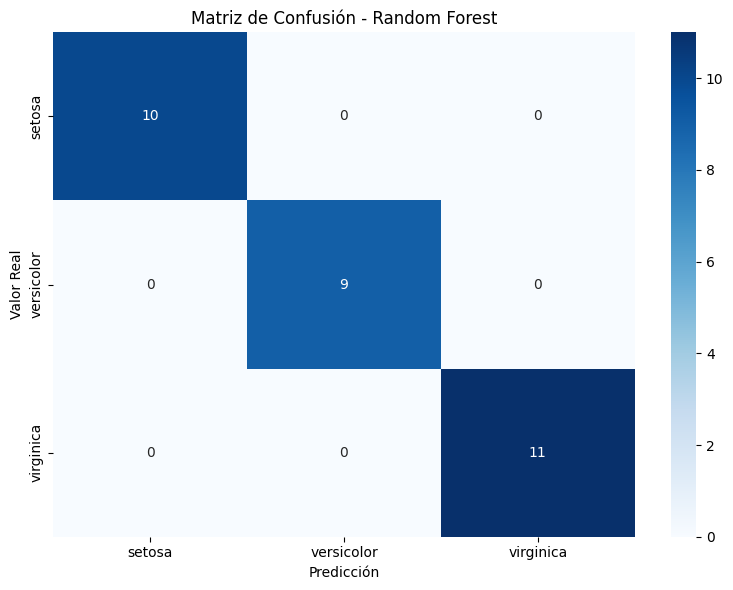

In [ ]:
#mlflow.set_tracking_uri("http://localhost:5000") 
#mlflow.end_run()
#entrenar_modelo_iris()
entrenar_modelo_iris_rf()
